# Cleaning

In [71]:
# Importing
import pandas as pd
import numpy as np
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt

path = "../data/raw/houses_moreinfo.csv"

df = pd.read_csv(path)


In [72]:
df.head()

,id,city,postal_code,district,province,price,type_sale,subtype,sale_type,state_construction,...,swimmingpool,has_balcony,has_terrace,has_attic,has_basement,construction_year,epc,heating,life_annuity,area_total
0,1882546,Wenduine,8420,Oostend,West Flanders,163000.0,HOUSE,CHALET,FOR_SALE,AS_NEW,...,0,NaN,NaN,NaN,NaN,2023.0,NaN,GAS,0,155.0
1,2784938,Heist-aan-Zee,8301,Brugge,West Flanders,108000.0,HOUSE,BUNGALOW,FOR_SALE,AS_NEW,...,0,NaN,NaN,NaN,NaN,2023.0,NaN,GAS,0,170.0
2,4679861,Oostende,8400,Oostend,West Flanders,330000.0,HOUSE,HOUSE,FOR_SALE,GOOD,...,0,NaN,1.0,NaN,NaN,NaN,B,NaN,0,65.0
3,5650273,Dilsen-Stokkem,3650,Maaseik,Limburg,535000.0,HOUSE,APARTMENT_BLOCK,FOR_SALE,NaN,...,0,NaN,NaN,NaN,NaN,1988.0,B,GAS,0,0.0
4,6349237,Corswarem,4257,Waremme,Liège,NaN,HOUSE_GROUP,HOUSE_GROUP,FOR_SALE,NaN,...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN


In [73]:
# Change name of places to lower
def format_name(x):
    return x.lower()

df["city"] = df.city.apply(format_name)
df["district"] = df.district.apply(format_name)
df["province"] = df.province.apply(format_name)

# Substitute 0 for Nan
df.replace(0, np.nan, inplace=True)


In [74]:
# Drop rows with life_annuity == 1
life_annuity = df.query("life_annuity == 1").index

df.drop(life_annuity, inplace=True)
df.shape

(44908, 33)

In [75]:
# Drop where price is NaN
df.dropna(subset=['price'], inplace=True)

In [76]:
# Drop useless columns
df.drop(['life_annuity', 'has_balcony', "sale_type", "type_sale", "furnished", "heating" ], axis=1, inplace=True)

In [108]:
# Drop subtypes that are not monoliving spaces
bad_columns = df["subtype"].isin(["CASTLE","APARTMENT_BLOCK", "MIXED_USE_BUILDING", "MANSION", "OTHER_PROPERTY", "MANOR_HOUSE"])
df_clean = df[~bad_columns]
# Drop empty living
df_clean.dropna(subset=['living_area'], inplace=True)
zero_rows = df_clean["living_area"] == 0 
df_clean = df_clean[~zero_rows]
# Drop empty total_area
df_clean.dropna(subset=['area_total'], inplace=True)
zero_rows1 = df_clean["area_total"] == 0
df_clean = df_clean[~zero_rows1]


df_clean.groupby("subtype").price.mean()

C:\Users\t_dei\AppData\Local\Temp\ipykernel_25460\3621434080.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



subtype
BUNGALOW                3.364770e+05
CHALET                  1.573134e+05
COUNTRY_COTTAGE         5.585352e+05
EXCEPTIONAL_PROPERTY    1.164985e+06
FARMHOUSE               7.224067e+05
HOUSE                   4.006107e+05
TOWN_HOUSE              3.763377e+05
VILLA                   9.495614e+05
Name: price, dtype: float64

In [78]:
# Exporting as a new CSV
# df_clean.to_csv("Cleaned_2", sep=',', index=False, encoding='utf-8')

# Start exploring

In [109]:
df_clean.shape


(30554, 27)

In [110]:
# Missing values
percent_missing = df_clean.isnull().sum() * 100 / len(df)
percent_missing

id                     0.000000
city                   0.000000
postal_code            0.000000
district               0.000000
province               0.000000
price                  0.000000
subtype                0.000000
state_construction    18.255135
living_area            0.000000
terrace_area          51.475116
garden_area           48.508800
rooms                 49.613988
bedrooms               0.452645
bathrooms              6.256606
livingroom_surface    38.814852
kitchen_surface       41.498552
facades               13.606911
has_garden            43.587151
kitchen               28.217913
fireplace             56.265797
swimmingpool          67.632462
has_terrace           33.429070
has_attic             49.198107
has_basement          42.282064
construction_year     27.930702
epc                   12.602822
area_total             0.000000
dtype: float64

### Usefull functions

In [111]:
def IQR (column):
    Q1 = column.quantile(0.25)
    Q3 = column.quantile(0.75)
    #quartiles = df[column].quantile([0.25, 0.75])
    iqr = Q3 - Q1
    lowerlimit = Q1 - 1.5*iqr
    upperlimit = Q3 + 1.5*iqr

    return lowerlimit, upperlimit

def thousants_point(x, n):
    return str('{:,}'.format(round(x), n).replace(',','.'))

### Usefull new columns

In [114]:
df_clean ["Price per Living Area"] = df_clean ["price"]/df_clean ["living_area"]
df_clean ["Price per Total Area"] = df_clean ["price"]/df_clean ["area_total"]
df_clean ["Outside area"] = df_clean["garden_area"] + df_clean["terrace_area"]


In [115]:
# Cleaning the price outliers via tukey IQR approach
lowerlimit, upperlimit  = IQR(df["price"])
price_no_outliers = df_clean[df_clean['price'].between(lowerlimit, upperlimit)]

# Define variables to be plotted together with graph
price_no_outliers_q1 = price_no_outliers["price"].quantile(0.25)
price_no_outliers_q3 = price_no_outliers["price"].quantile(0.75)
average_price_no_outliers = price_no_outliers.price.mean()


# Sets up texts to be displayed with the above variables
text_average = "Avg € " + thousants_point(average_price_no_outliers,0)
text_q1 = "Q1 € " + thousants_point(price_no_outliers_q1,0)
text_q3 = "Q3 € " + thousants_point(price_no_outliers_q3,0)


## Graph number properties per price

In [116]:

# Starts setting up histogram of prices
fig = px.histogram(price_no_outliers, x="price", nbins=40, labels={'price': "Price"}) 
fig.update_layout(bargap=0.2)

# Vertical lines that are added
fig.add_vline(x=average_price_no_outliers, line_dash = 'dash', line_color = 'firebrick', annotation_text= text_average, annotation_position="top")
fig.add_vline(x=price_no_outliers_q1, line_dash = 'dash', line_color = 'green', annotation_text= text_q1, annotation_position="top left")
fig.add_vline(x=price_no_outliers_q3, line_dash = 'dash', line_color = 'green', annotation_text= text_q3, annotation_position="top right")

# Making it a bit more pretty and clean
fig.update_layout(
    title = "Pricing distribution", 
    title_font=dict(size=20,
                    color='blue',
                    family='Arial'),
    title_x=0.1,  
)

# Display plot
fig.show()


## Graph number of houses per price/m2

In [87]:

# Subsetting dataframe for variables to be explored
price_area = price_no_outliers[["id", "price", "area_total", "living_area", "district"]]

# Calculates the price/ m2
price_area["Price per Living Area"] = price_area["price"]/price_area["living_area"]

# Cleans data from outliers via Tukey IQR method
lowerlimit, upperlimit  = IQR(price_area["Price per Living Area"])
price_area = price_area[price_area["Price per Living Area"].between(lowerlimit, upperlimit)]

# Set up info to be added to plot (average) and its text
average_price_living_area = price_area["Price per Living Area"].mean()
text_average_living = "Avg € " + thousants_point(average_price_living_area,0) + "/m²"

# Starts setting up the histogram
fig = px.histogram(price_area, x="Price per Living Area", nbins = 50, title="Number of houses versus price per m²", labels={"Price per Living Area": "Price per area (€ / m²)"}) 
fig.add_vline(x=average_price_living_area, line_dash = 'dash', line_color = 'firebrick', annotation_text= text_average_living, annotation_position="top")
fig.update_layout(bargap=0.2)

# Displays the plot
fig.show()

C:\Users\t_dei\AppData\Local\Temp\ipykernel_25460\891296760.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



## Graph avg house price/m2 versus year and EPC

In [88]:
# Selecting only columns with EPC correctly inputed
mask_epc = price_no_outliers['epc'].isin(["A++", "A+", "A", "B", "C", "D", "E", "F", "G"])
compare_epc= price_no_outliers[mask_epc]

# Grouping interesting variables per EPC type
compare_epc = compare_epc.groupby('epc', as_index=False)[["Price per Living Area",'construction_year','Price per Total Area']].mean().round()

# Starts bar plot to compare EPC, average pricing and construction year
fig = px.bar(compare_epc, x='epc', y='Price per Living Area', color='construction_year', title="Avg house price and construction year per EPC", labels = {'Price per Living Area':'Avg House Price / living area (€/m2)', 'epc': "EPC", "construction_year": "Avg year construction"}, color_continuous_scale = 'Turbo')
fig.update_xaxes(categoryorder='array', categoryarray= ['A++', 'A+', 'A', 'B', 'C', 'D', 'E', 'G'])
fig.show()

## Graph price/m2 per state of construction and year

In [119]:
# Selecting rows with valid data for construction state
type_state = ["AS_NEW","JUST_RENOVATED", "GOOD", "TO_BE_DONE_UP", "TO_RENOVATE", "TO_RESTORE"]
mask_state_construction = price_no_outliers['state_construction'].isin(type_state)
compare_state_construction= price_no_outliers[mask_epc]

# Taking the mean of pricing
compare_state_construction = compare_state_construction.groupby('state_construction', as_index=False)[['Price per Living Area','construction_year','living_area']].mean().round()


# Starts bar plot to compare State of Construction, average pricing and construction year
prettier_labels = {"AS_NEW": "As new","JUST_RENOVATED": "Just renovated", "GOOD": "Good", "TO_BE_DONE_UP": "To be done up", "TO_RENOVATE": "To renovate", "TO_RESTORE": "To restore", "construction_year": "Year", "state_construction" : "State Construction", "price": "Price in €"}
fig = px.bar(compare_state_construction, x='state_construction', y='Price per Living Area', color='construction_year', title="Avg house price, construction year per Construction State", labels = prettier_labels, color_continuous_scale = 'Bluered')
fig.update_xaxes(categoryorder='array', categoryarray= ['A++', 'A+', 'A', 'B', 'C', 'D', 'E', 'G'])
fig.show()


## Make qualitative data to be quantitative

In [127]:
# Designates a numeric scale for qualitative data
epc_sub= {"A++":8, "A+":7, "A":6,"B":5,"C":4,"D":3,"E":2,"F": 1,"G":0}
state_sub = {"AS_NEW":5, "GOOD":4, "JUST_RENOVATED":3 , "TO_BE_DONE_UP":2, "TO_RENOVATE":1, "TO_RESTORE":0 }


# Replaces string values for the numeric scale created
correlation_var= price_no_outliers.replace({"epc":epc_sub, "state_construction": state_sub})
# Filters out rows that have invalid input that were not able to be substituted before
correlation_var = correlation_var[correlation_var['epc'].isin([0,1,2,3,4,5,6,7,8, np.nan])]
correlation_var = correlation_var[correlation_var["state_construction"].isin([0,1,2,3,4,5, np.nan])]

# Correct names of columns before plotting to something prettier
correct_names = {"price": "Price", "living_area": "Living Area", "state_construction": "State Construction", "construction_year":"Construction year", "epc": "EPC" }
correlation_var.rename(columns= correct_names, inplace = True)

correlation_var.head()

C:\Users\t_dei\AppData\Local\Temp\ipykernel_25460\3427123033.py:7: FutureWarning:

Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`



,id,city,postal_code,district,province,Price,subtype,State Construction,Living Area,terrace_area,...,swimmingpool,has_terrace,has_attic,has_basement,Construction year,EPC,area_total,Price per Living Area,Price per Total Area,Outside area
0,1882546,wenduine,8420,oostend,west flanders,163000.0,CHALET,5.0,62.0,NaN,...,NaN,NaN,NaN,NaN,2023.0,NaN,155.0,2629.032258,1051.612903,NaN
1,2784938,heist-aan-zee,8301,brugge,west flanders,108000.0,BUNGALOW,5.0,51.0,NaN,...,NaN,NaN,NaN,NaN,2023.0,NaN,170.0,2117.647059,635.294118,NaN
8,6675519,zonhoven,3520,hasselt,limburg,392422.0,HOUSE,NaN,206.0,NaN,...,NaN,NaN,NaN,NaN,2023.0,NaN,370.0,1904.961165,1060.600000,NaN
11,7066131,bredene,8450,oostend,west flanders,245000.0,HOUSE,5.0,76.0,NaN,...,NaN,NaN,NaN,NaN,2023.0,5,150.0,3223.684211,1633.333333,NaN
15,7222190,geel,2440,turnhout,antwerp,335527.0,HOUSE,NaN,160.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,431.0,2097.043750,778.484919,NaN


### Explore correlation heatmap between price, area, state, construction year

In [132]:
# Select columns to do the correlation
correlation1= correlation_var[["Price per Living Area", "Living Area", 
"State Construction", "Construction year", "EPC"]]
# Creates dataframe of the correlations
correlation_graph_1 = correlation1.corr()
correlation_graph_1.head()

,Price per Living Area,Living Area,State Construction,Construction year,EPC
Price per Living Area,1.000000,-0.160469,0.339546,0.162032,0.301381
Living Area,-0.160469,1.000000,0.027388,0.003312,0.089240
State Construction,0.339546,0.027388,1.000000,0.213809,0.560970
Construction year,0.162032,0.003312,0.213809,1.000000,0.240554
EPC,0.301381,0.089240,0.560970,0.240554,1.000000


Text(0.5, 1.0, 'Correlation Heatmap')

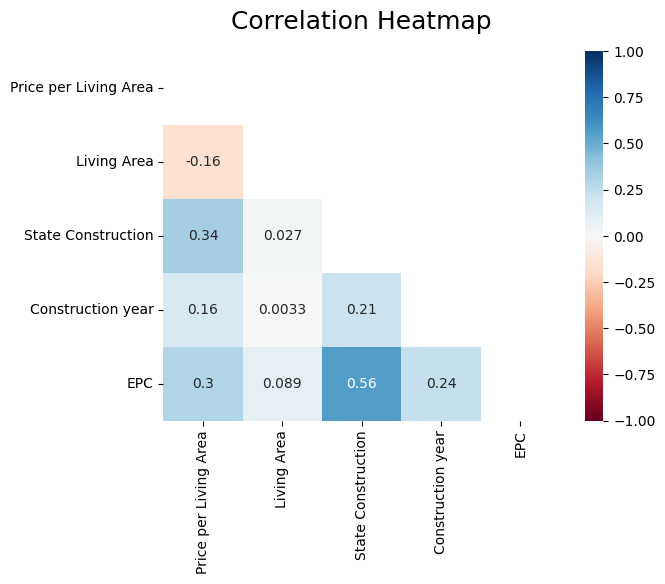

In [133]:

# Creates the heatmap of correlations in matrix form via seaborn
# Creates mask with numeric matrix that will exclude the upper half of the matrix
mask = np.triu(np.ones_like(correlation_graph_1 , dtype=bool))

# Creates the heatmap and plots it
heatmap = sns.heatmap(correlation_graph_1 , mask=mask, vmin=-1, vmax=1, annot=True, cmap='RdBu')
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':18}, pad=16)


In [ ]:
# New correlation map for boolean variables



TO DO: explore boxplots, explore data per geographical location (price square meters per district, size of living per distric, volume per district), do scatter plot to see evolution of price per year (with a tendency curve). See put error margin in the average price graph per epc and construction state. Buble chart of price, volume (size bubble) and district).
Percentage of houses that are new, old, to renovate. Percentage of houses per any variable? ARE CHART X is PRICE, Y is VOLUME AND EACH LINE IS A DISTRICT?

House price per income per district? House availability per population? Correlation price number of rooms?
Age of building per district?

Number of bedrooms per district (box chart that piles up one over the other), also state of building, and epc. Pie charts of kitchen, fireplace etc (see if some municipality is more on those). Pie chart numher of bedrooms?